In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import csv
import math
from collections import defaultdict
import copy
from random import shuffle

##### type_data = 'GSC | HUMAN'
TRAINING_PERCENTAGE = 80
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10

GSC_DATASET_PATH = 'GSC-Dataset/GSC-Features-Data/'
HUMAN_DATASET_PATH = 'HumanObserved-Dataset/HumanObserved-Features-Data/'

HUMAN_FEATURE_DATASET = 'HumanObserved-Features-Data.csv'
GSC_FEATURE_DATASET = 'GSC-Features.csv'

DIFF_TARGET_DATASET = 'diffn_pairs.csv'
SAME_TARGET_DATASET = 'same_pairs.csv'

In [2]:
class DataModel:
    def load_feature_map(self, type, file_path = None):
        dataset = defaultdict(lambda : [])
        with open(file_path, "r") as f:
            reader = csv.reader(f)
            reader = list(reader)
            del reader[0]
            for row in reader:
                if type != 'GSC':
                    del row[0]
                image_name = row[0]
                del row[0]
                dataset[image_name] = row
        return dataset
    
    def load_target(self, file_path):
        data = []
        with open(file_path, "r") as f:
            reader = csv.reader(f)
            data = list(reader)
            del data[0]
        return data
        
        
    def generate_dataset(self, type, file_path, csv_path):
        feature = self.load_feature_map(type, file_path + csv_path)
        diff = self.load_target(file_path + DIFF_TARGET_DATASET)
        shuffle(diff)
        same = self.load_target(file_path + SAME_TARGET_DATASET)
        
        same.extend(diff[0:len(same)])
        shuffle(same)
        for data in same:
            img_id_1 = data[0]
            img_id_2 = data[1]
            data.append([int(x) for x in feature[img_id_1]])
            data.append([int(x) for x in feature[img_id_2]])
        return same

    def generate_feature_concatenation(self, dataset):
        concat_dataset = []
        target = []
        l = len(dataset[0]) - 1
        for concat in dataset:
            row = concat[l]
            row_ = concat[l - 1]
            row.extend(row_)
            concat_dataset.append(row)
            target.append(int(concat[2]))
        return concat_dataset,target
    
    def show(self, dataset):
    ############### Data representation ###############
        df = pd.DataFrame(np.array(dataset), columns=['f_' + str(x + 1) for x in range(len(dataset[0]))])
        df.style.set_properties(**{'background-color': 'black',
                                   'color': 'lawngreen',
                                   'border-color': 'white'})
        print(df)

    def generate_subtraction(self, dataset):
        feature_subtract = []
        target = []
        l = len(dataset[0]) - 1
        for subtract in dataset:
            row_1 = subtract[l]
            row_2 = subtract[l - 1]
            row = [abs(row_1[i] - row_2[i]) for i in range(0, len(row_1))]
            feature_subtract.append(row)
            target.append(int(subtract[2]))
        return feature_subtract, target
    

    def get_segregated_dataset(self, dataset, target, start_percent, end_percent):
        start = int(len(dataset) * (start_percent*0.01))
        end = int(len(dataset) * (end_percent*0.01))
        return np.array(dataset[start: end]), np.array(target[start:end])
    

In [3]:
class LinearRegression:    
    C_Lambda = 0.3   
    learningRate = 0.03
    La           = 2
    EPOCHS      = 400

    def __init__(self, training_set, validation_set, testing_set):
        self.number_of_features = training_set.shape[1]
        self.M = training_set.shape[1]
        kmeans               = KMeans(n_clusters=self.M, random_state=0).fit(training_set)
        self.Mu              = kmeans.cluster_centers_
        self.BigSigma        = self.GenerateBigSigma(training_set)
        self.PHI_MATRIX      = self.GetPhiMatrix(training_set, self.Mu, self.BigSigma) 
        self.VAL_PHI_MATRIX  = self.GetPhiMatrix(validation_set, self.Mu, self.BigSigma)
        self.TEST_PHI_MATRIX = self.GetPhiMatrix(testing_set, self.Mu, self.BigSigma)
    
    
    def sgd_form(self, training_target_set, validation_target_set, testing_target_set):
        ################## SGD  #################
        W_Now = np.zeros((self.number_of_features,))
        
        L_Erms_Val  = []
        L_Erms_TR   = []
        L_Erms_Test = []
        W_Mat       = []

        for i in range(0, self.EPOCHS):
            Delta_E_D     = -np.dot((training_target_set[i] - np.dot(np.transpose(W_Now), self.PHI_MATRIX[i])),self.PHI_MATRIX[i])
            La_Delta_E_W  = np.dot(self.La, W_Now)
            Delta_E       = np.add(Delta_E_D, La_Delta_E_W) 
            Delta_W       = -np.dot(self.learningRate, Delta_E) ## the delta weight is multiplied with the lambda value
            W_T_Next      = W_Now + Delta_W ## the initial weight gets updated with the Delta_W + W
            W_Now         = W_T_Next
            try:
                #-----------------TrainingData Accuracy---------------------#
                TR_TEST_OUT   = self.GetValTest(self.PHI_MATRIX,W_T_Next) 
                Erms_TR       = self.GetErms(TR_TEST_OUT, training_target_set)
                L_Erms_TR.append(float(Erms_TR.split(',')[1]))


                #-----------------ValidationData Accuracy---------------------#
                VAL_TEST_OUT  = self.GetValTest(self.VAL_PHI_MATRIX,W_T_Next) 
                Erms_Val      = self.GetErms(VAL_TEST_OUT, validation_target_set)
                L_Erms_Val.append(float(Erms_Val.split(',')[1]))

                #-----------------TestingData Accuracy---------------------#
                TEST_OUT  = self.GetValTest(self.TEST_PHI_MATRIX,W_T_Next) 
                Erms_Test = self.GetErms(TEST_OUT, testing_target_set)
                L_Erms_Test.append(float(Erms_Test.split(',')[1]))


            except Exception as e:
                print(e)
                print(self.learningRate)


        print ('----------Gradient Descent Solution--------------------')
        print ("M = 15 \nLambda  = 0.0001\neta=0.01")
        print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
        print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
        print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

    def closed_form_solution(self, training_target_set, validation_target_set, testing_target_set):
        W                  = self.GetWeightsClosedForm(self.PHI_MATRIX, training_target_set, (self.C_Lambda)) 
        TR_TEST_OUT        = self.GetValTest(self.PHI_MATRIX, W)
        VAL_TEST_OUT       = self.GetValTest(self.VAL_PHI_MATRIX, W)
        TEST_OUT           = self.GetValTest(self.TEST_PHI_MATRIX, W)

        TrainingAccuracy   = str(self.GetErms(TR_TEST_OUT, training_target_set))
        ValidationAccuracy = str(self.GetErms(VAL_TEST_OUT, validation_target_set))
        TestAccuracy       = str(self.GetErms(TEST_OUT, testing_target_set))

        print ('----------Closed Form Solution--------------------')
        print ("M = 15 \nLambda  = 0.0001\neta=0.01")
        print ("E_rms Training   = " + str(np.around(float(TrainingAccuracy.split(',')[1]),5)))
        print ("E_rms Validation   = " + str(np.around(float(ValidationAccuracy.split(',')[1]),5)))
        print ("E_rms Testing   = " + str(np.around(float(TestAccuracy.split(',')[1]),5)))

    
    
    def GenerateBigSigma(self, Data):
        DataT = np.transpose(Data)
        l = len(Data[0])
        BigSigma = np.zeros((l, l))
        for i in range(0, len(DataT)):
            BigSigma[i][i] = np.var(Data[i])
        return BigSigma 

    def GetPhiMatrix(self, Data, MuMatrix, BigSigma):
        DataT = np.transpose(Data)
        PHI = np.zeros((len(Data), len(MuMatrix)))
        BigSigInv = np.linalg.inv(BigSigma)
        Data = np.array(Data)
        for C in range(0, len(MuMatrix)):
            for R in range(0, len(Data)):
                PHI[R][C] = self.GetRadialBasisOut(Data[R], MuMatrix[C], BigSigInv) 
        return PHI

    def GetWeightsClosedForm(self, PHI, T, Lambda):
        Lambda_I = np.identity(len(PHI[0]))
        for i in range(0,len(PHI[0])):
            Lambda_I[i][i] = Lambda
        PHI_T       = np.transpose(PHI) ### taking transpose of matrix using Numpy
        PHI_SQR     = np.dot(PHI_T, PHI)### Multipling TRAINING_PHI MATRIX with TRANSPOSE MATRIX
        PHI_SQR_LI  = np.add(Lambda_I, PHI_SQR)### THE regularization parameter is multiplied with the PHI_SQR matrix
        PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI) ### The inverse of matrix is calculated 
        INTER       = np.dot(PHI_SQR_INV, PHI_T)### taking dot product of PHI_SQR_INV, PHI_T
        W           = np.dot(INTER, T) ### taking dot product of INTER, T
        ##print ("Training Weights Generated..")
        return W

    def GetValTest(self, VAL_PHI,W):
        Y = np.dot(W,np.transpose(VAL_PHI))
        ##print ("Test Out Generated..")
        return Y

    ## The root mean square is calculated and is minimized so that the error for the output values could be reduced
    def GetErms(self, VAL_TEST_OUT,ValDataAct):
        sum = 0.0
        t=0
        accuracy = 0.0
        counter = 0
        val = 0.0
        for i in range (0,len(VAL_TEST_OUT)):
            sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
            if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
                counter+=1
        accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
        ##print ("Accuracy Generated..")
        ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
        return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))
    
    def GetRadialBasisOut(self, DataRow, MuRow, BigSigInv):    
        phi_x = math.exp(-0.5*self.GetScalar(DataRow, MuRow,BigSigInv))
        return phi_x

    def GetScalar(self, DataRow, MuRow, BigSigInv):  
        R = np.subtract(DataRow, MuRow)
        T = np.dot(BigSigInv, np.transpose(R))  
        L = np.dot(R,T)
        return L

In [4]:
################# logistic regression  ###############
class LogisticRegression:
    learning_rate = 0.3
    epochs = 5000
    
    def __init__(self, features, target):
        self.features = features
        self.target = target
    
    def sigmoid(self, scores):
        return 1 / (1 + np.exp(-scores))

    def logistic_regression(self):
        intercept = np.ones((self.features.shape[0], 1))
        self.features = np.hstack((intercept, self.features))
        weights = np.zeros(self.features.shape[1])
        
        for step in range(self.epochs):
            scores = np.dot(self.features, weights)
            predictions = self.sigmoid(scores)
            output_error_signal = self.target - predictions
            gradient = np.dot(self.features.T, output_error_signal)
            weights += self.learning_rate * gradient
        self.W = weights

    def final_score(self, features, target):
        final_scores = np.dot(np.hstack((np.ones((features.shape[0], 1)), features)), self.W)
        preds = np.round(self.sigmoid(final_scores))
        return (preds == target).sum().astype(float) / len(preds)

In [5]:
# ############ Neural Networks #####################
from keras.utils import to_categorical
from keras.models import Sequential # for building the keras model we need to import Sequential model which helps in adding the different optimizers in betweent the input and output layer
from keras.layers import Dense, Activation, Dropout # Different activation functions like Rmprop, Adam, Adagrad
from keras.callbacks import EarlyStopping, TensorBoard # to visualize the tensorflow graph we use Tensorboard
from keras_contrib.layers.advanced_activations import SReLU
import numpy as np 

drop_out = 0.2
first_dense_layer_nodes  = 64
second_dense_layer_nodes = 2
validation_data_split = 0.2 
num_epochs = 10000# The number of times the model gets trained for a specific training dataset
model_batch_size = 128# The batches in which the data is fitted in the model
tb_batch_size = 32 
early_patience = 100

class NeuralNetworkModel:
    def __init__(self, training_set, validation_set, testing_set):
        self.number_of_features = training_set.shape[1]
        self.input_size = training_set.shape[1]
        self.training_set = training_set
        self.validation_set = validation_set
        self.testing_set = testing_set
        self.model = self.get_model()
        
    def get_model(self):
        # Why do we need a model?
        # Inorder to calculate weights and predict the testing data we need to train our model using training data and its corresponding outputs.
        # The Neural network model we are building requires 2 weighted matrices which are multiplied by the input matrix and the output matrix 
        # and trained using different hyper parameters like drop out ratio, learning rate , number of neurons etc. 

        # Why use Dense layer and then activation?
        # It is a layer of Neurons which has a bias factor, activation factor and dot product of kernel and input layer.
        # Inorder to calculate weight between to layers the input from the previous layer is multiplied with a weight matrix using 
        # activation function with a bias. The reason for adding a dense layer first and then activation function is that for a Dense layer we need to define an activation function
        # which could be used for calculating the weight matrix.
        # Basically output = activation(dot(input, kernel) + bias) (from documentation) is the Dense layer function which is calculated using the next activation fucntion

        # Why use sequential model with layers?
        # Since we are using a hidden layer in between which has 2 weighted matrices we need to implement different activation function and optimizer to calculate the weighted matrix.
        # The multiplication output of one matrix is dependent on the other as this process occurs sequentially for training data. Therefore we need to use a sequential approach to calculate the weights.
        # In Other words, sequential model is a linear stacks of neuron hidden layers which require sequential calculations as input and output of each weight are dependednt on previosu layer.
        model = Sequential()
        model.add(Dense(first_dense_layer_nodes, input_dim=self.input_size)) # the input_size is 18 which is the number of bits needed to represent all number from 101 - 1000
                                                                        # first_dense_layer_nodes is the number of neurons considered in the hidden layer
        model.add(SReLU()) 

        # Why dropout?
        # The dropout means not taking into consideration some neurons because of which they are not considered in the forward pass and all the neurons associated with them before are 
        # not taken into consideration. This is used generally for feature attributes which are active only for special cases 
        # This is generally done to make the training model more robust and more flexible for different values as it  has better generalization
        model.add(Dropout(drop_out))

        model.add(Dense(second_dense_layer_nodes))
        model.add(Activation('softmax'))
        # Why Softmax?
        # Since softmax gives values between 0 and 1 which is how are model is being trained to give output. Generally Softmax
        # is used for output layer. 

        model.summary()

        # Why use categorical_crossentropy?
        # categorical_crossentropy is a loss function which needs to be minimized for a model. Inorder to imprve accuracy 
        # the value of loss function should be as low as possible.
        model.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

    def fit(self, training_target_set):
        tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
        # for visualizing the tensorflow model we use Tensorboard.
        # The different parameters like log_dir = for saving the log information for every epoch
        # batch_Size = for executing every epoch the number of dataset elements to be considered
        earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
        # EarlyStopping is used to visulize the different hyper parameters in the process of traiing the model which helpsin finding 
        # different values at every epochs and accuracy
        # Read Dataset
        # Process Dataset
        history = self.model.fit(self.training_set
                            , to_categorical(training_target_set)
                            , validation_split=validation_data_split
                            , epochs=num_epochs
                            , batch_size=model_batch_size
                            , callbacks = [tensorboard_cb,earlystopping_cb]
                           ) 
        return history

    def show(self, history):
        %matplotlib inline
        df = pd.DataFrame(history.history)
        df.plot(subplots=True, grid=True, figsize=(10,15))
        
    def predict(self, testing_target_set):
        processedTestData  = self.testing_set 
        processedTestLabel = to_categorical(testing_target_set)
        predictedTestLabel = []
        wrong = 0
        right = 0

        for i,j in zip(processedTestData, processedTestLabel):
            y = self.model.predict(np.array(i).reshape(-1, self.number_of_features))
            if j.argmax() == y.argmax():
                right = right + 1
            else:
                wrong = wrong + 1

        print("Errors: " + str(wrong), " Correct :" + str(right))

        print("Testing Accuracy: " + str(right/(right+wrong)*100))

Using TensorFlow backend.


## Human Data Set for Feature Concatenation ##

The Human Observed dataset for feature concatenation is created using adding the features of image 1 with features of image 2. The input features are 18 for Human Observed dataset. There are total of 18 features for a pair of handwritten “AND” sample (9 features for each sample). The dataset is named as “HumanObserved-Features-Data”. Dataset is available on UBLearns under the Assignments section in “HumanObserved-Dataset.zip”. The entire
dataset consists of 791 same writer pairs and 293,032 different writer pairs(rows).

The Data is built using HumanObserved-Feature-Dataset and segregated into contatenation and subtraction sets. The Subtraction set contains 9 features and contenation contains 18 features. 

In [6]:
human = DataModel()
human_dataset = human.generate_dataset('HUMAN',HUMAN_DATASET_PATH, HUMAN_FEATURE_DATASET)

human_feature_concatenation, human_target = human.generate_subtraction(human_dataset)

training_set, training_target_set = human.get_segregated_dataset(human_feature_concatenation, human_target, 0, TRAINING_PERCENTAGE)
validation_set, validation_target_set = human.get_segregated_dataset(human_feature_concatenation, human_target, TRAINING_PERCENTAGE, TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE)
testing_set, testing_target_set = human.get_segregated_dataset(human_feature_concatenation, human_target, TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE, 100)


print('Data set size  ' + str(len(human_dataset)))
print('Feature Concatenation set size   ' + str(len(human_feature_concatenation)))
print('Trainin Data set size   ' + str(len(training_set)))
print('Validation Data set size   ' + str(len(validation_set)))
print('Testing Data set size   ' + str(len(testing_set)))

Data set size  1582
Feature Concatenation set size   1582
Trainin Data set size   1265
Validation Data set size   158
Testing Data set size   159


In [7]:
ll = LinearRegression(training_set, validation_set, testing_set)
ll.closed_form_solution(training_target_set, validation_target_set, testing_target_set)

----------Closed Form Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.59975
E_rms Validation   = 0.60744
E_rms Testing   = 0.58275


In [8]:
ll.sgd_form(training_target_set, validation_target_set, testing_target_set)

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.70585
E_rms Validation = 0.68357
E_rms Testing    = 0.72983


In [9]:
lr = LogisticRegression(training_set, training_target_set)
lr.logistic_regression()
print ('----------  Logistic Regression Solution   --------------------')
print(lr.final_score(training_set, training_target_set))
print(lr.final_score(validation_set, validation_target_set))
print(lr.final_score(testing_set, testing_target_set))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


----------  Logistic Regression Solution   --------------------
0.509090909090909
0.5189873417721519
0.46540880503144655


In [10]:
nn = NeuralNetworkModel(training_set, validation_set, testing_set)
history = nn.fit(training_target_set)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
s_re_lu_1 (SReLU)            (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________
Train on 1012 samples, validate on 253 samples
Epoch 1/10000
1012/1012 [==============================] - 0s 390us/step - loss: 0.7650 - acc

1012/1012 [==============================] - 0s 36us/step - loss: 0.6915 - acc: 0.5326 - val_loss: 0.6888 - val_acc: 0.5296
Epoch 53/10000
1012/1012 [==============================] - 0s 27us/step - loss: 0.6884 - acc: 0.5474 - val_loss: 0.6902 - val_acc: 0.5455
Epoch 54/10000
1012/1012 [==============================] - 0s 26us/step - loss: 0.6840 - acc: 0.5534 - val_loss: 0.6893 - val_acc: 0.5138
Epoch 55/10000
1012/1012 [==============================] - 0s 30us/step - loss: 0.6867 - acc: 0.5455 - val_loss: 0.6896 - val_acc: 0.5178
Epoch 56/10000
1012/1012 [==============================] - 0s 34us/step - loss: 0.6846 - acc: 0.5553 - val_loss: 0.6892 - val_acc: 0.5257
Epoch 57/10000
1012/1012 [==============================] - 0s 32us/step - loss: 0.6910 - acc: 0.5425 - val_loss: 0.6893 - val_acc: 0.5178
Epoch 58/10000
1012/1012 [==============================] - 0s 35us/step - loss: 0.6834 - acc: 0.5504 - val_loss: 0.6908 - val_acc: 0.5296
Epoch 59/10000
1012/1012 [================

Epoch 111/10000
1012/1012 [==============================] - 0s 30us/step - loss: 0.6803 - acc: 0.5692 - val_loss: 0.6907 - val_acc: 0.5455
Epoch 112/10000
1012/1012 [==============================] - 0s 30us/step - loss: 0.6721 - acc: 0.5751 - val_loss: 0.6908 - val_acc: 0.5375
Epoch 113/10000
1012/1012 [==============================] - 0s 27us/step - loss: 0.6764 - acc: 0.5662 - val_loss: 0.6914 - val_acc: 0.5296
Epoch 114/10000
1012/1012 [==============================] - 0s 33us/step - loss: 0.6719 - acc: 0.5800 - val_loss: 0.6911 - val_acc: 0.5415
Epoch 115/10000
1012/1012 [==============================] - 0s 30us/step - loss: 0.6794 - acc: 0.5632 - val_loss: 0.6914 - val_acc: 0.5375
Epoch 116/10000
1012/1012 [==============================] - 0s 33us/step - loss: 0.6704 - acc: 0.5593 - val_loss: 0.6912 - val_acc: 0.5415
Epoch 117/10000
1012/1012 [==============================] - 0s 36us/step - loss: 0.6753 - acc: 0.5830 - val_loss: 0.6912 - val_acc: 0.5455
Epoch 118/10000
1012

Errors: 70  Correct :89
Testing Accuracy: 55.9748427672956


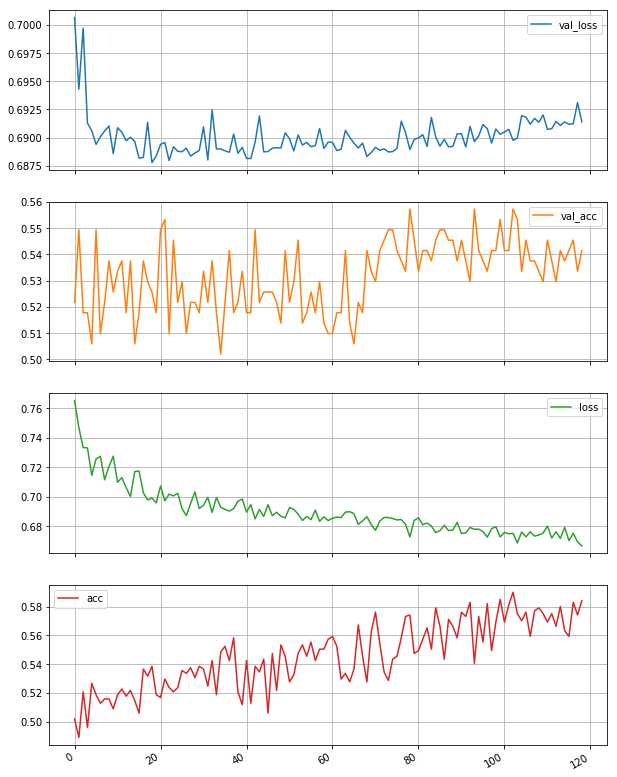

In [11]:
nn.show(history)
nn.predict(testing_target_set)